In [1]:
%reload_ext autoreload
%autoreload 2

## Import packages

In [2]:
import sys

sys.path.append(r"D:\github\ripple_heterogeneity\python")
import functions, loading, add_new_deep_sup, pairwise_ccg_deep_sup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import random


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## default plotting

In [3]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

functions.set_plotting_defaults()

## get list of sessions and run analysis

In [203]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

not_to_use = (df["basepath"].str.contains("OMLproject", case=False)) | (
    df["basepath"].str.contains("ORproject", case=False)
)
df = df.loc[~not_to_use]

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake_5ms_bins"
pairwise_ccg_deep_sup.run(df,save_path,parallel=True,states="wake")

In [204]:
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_counts_par"
ccgs, ccg_id_df = pairwise_ccg_deep_sup.load_results(save_path)


## add layer comparison label

In [205]:
ccg_id_df['layer_label'] = 'unknown'

idx = (ccg_id_df.deepSuperficial_ref == 'Deep') & (ccg_id_df.deepSuperficial_target == 'Deep')
ccg_id_df.loc[idx,'layer_label'] = 'same_layer'
idx = (ccg_id_df.deepSuperficial_ref == 'Superficial') & (ccg_id_df.deepSuperficial_target == 'Superficial')
ccg_id_df.loc[idx,'layer_label'] = 'same_layer'

idx = (ccg_id_df.deepSuperficial_ref == 'Deep') & (ccg_id_df.deepSuperficial_target == 'Superficial')
ccg_id_df.loc[idx,'layer_label'] = 'cross_layer'
idx = (ccg_id_df.deepSuperficial_ref == 'Superficial') & (ccg_id_df.deepSuperficial_target == 'Deep')
ccg_id_df.loc[idx,'layer_label'] = 'cross_layer'

## add animal id

In [23]:
# animal_id = [loading.get_animal_id(basepath) for basepath in ccg_id_df.basepath]
# ccg_id_df['animal_id'] = animal_id
for basepath in ccg_id_df.basepath.unique():
    ccg_id_df.loc[ccg_id_df.basepath == basepath,'animal_id'] = loading.get_animal_id(basepath)

In [25]:
# ccg_id_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_counts_par_id_df.csv")

## plot correlation

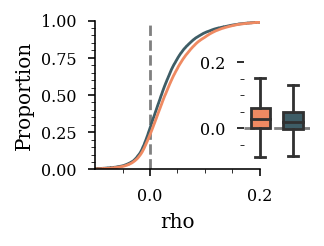

In [105]:
import custom_plots

group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}
sns.set_palette(sns.color_palette(group_colors.values()))


fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1.5, 1)), edgecolor='k')
axs = plt.gca()

box_ax = custom_plots.plot_ecdf_box(
    data=ccg_id_df,
    x="rho",
    hue="layer_label",
    hue_order=group_colors.keys(),
    x_offset=0.7,
    y_offset=0.04,
    showfliers=False,
    ax=axs,
    fig=fig)
axs.set_xlim(-0.1, .2)
box_ax.set_ylim(-0.1, .2)
axs.axvline(0, color='grey', linestyle='--',zorder=-100)
box_ax.axhline(0, color='grey', linestyle='--',zorder=-100)

plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_corr_deep_sup.svg'),dpi=300,bbox_inches='tight')


## mean of z-score

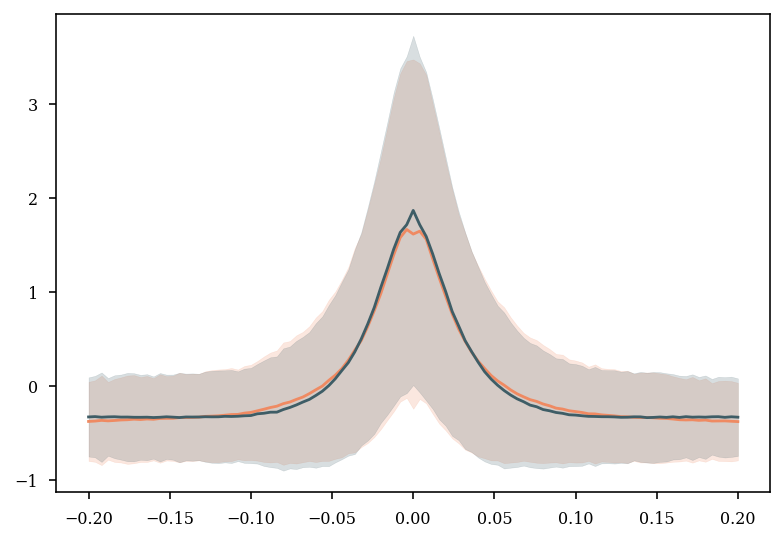

In [97]:
from scipy.stats import zscore

ccgs_z = zscore(ccgs, axis=0)

group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}

idx = ccg_id_df.layer_label == "same_layer"
y = np.nanmean(ccgs_z.loc[:,idx],axis=1)
x = ccgs_z.index
std = np.nanstd(ccgs_z.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

idx = ccg_id_df.layer_label == "cross_layer"
y = np.nanmean(ccgs_z.loc[:,idx],axis=1)
x = ccgs_z.index
sem = np.nanstd(ccgs_z.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)

plt.show()

In [ ]:
# temp_ccg_df = ccg_id_df[ccg_id_df.basepath == "Z:\\Data\\GrosmarkAD\\Achilles\\Achilles_10252013"]
# temp_ccgs_z = ccgs_z.loc[:,ccg_id_df.basepath == "Z:\\Data\\GrosmarkAD\\Achilles\\Achilles_10252013"]

# WINDOW = 30

# idx = temp_ccg_df.layer_label == "same_layer"
# ccg_smooth = gaussian_filter1d(temp_ccgs_z.loc[:,idx],WINDOW,axis=1)
# x = temp_ccgs_z.index
# std = np.nanstd(ccg_smooth,axis=1)
# plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
# plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

# idx = temp_ccg_df.layer_label == "cross_layer"
# ccg_smooth = gaussian_filter1d(temp_ccgs_z.loc[:,idx],WINDOW,axis=1)
# y = np.nanmean(ccg_smooth,axis=1)
# x = temp_ccgs_z.index
# sem = np.nanstd(ccg_smooth,axis=1)
# plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
# plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)
# plt.legend()
# plt.show()

## normalize by subtracting slow component 

In [206]:
def get_z_transform(ccgs):
    """    
    """
    z = []
    for ccg in ccgs.values.T:
        ccg_smooth = gaussian_filter1d(ccg,30)
        z.append((ccg - ccg_smooth) / np.sqrt(ccg_smooth))
    ccgs_out = ccgs.copy()    
    ccgs_out[:] = np.vstack(z).T
    return ccgs_out

ccgs_z = get_z_transform(ccgs)

C:\Users\Cornell\AppData\Local\Temp\ipykernel_16848\3527765283.py:7: RuntimeWarning: invalid value encountered in true_divide


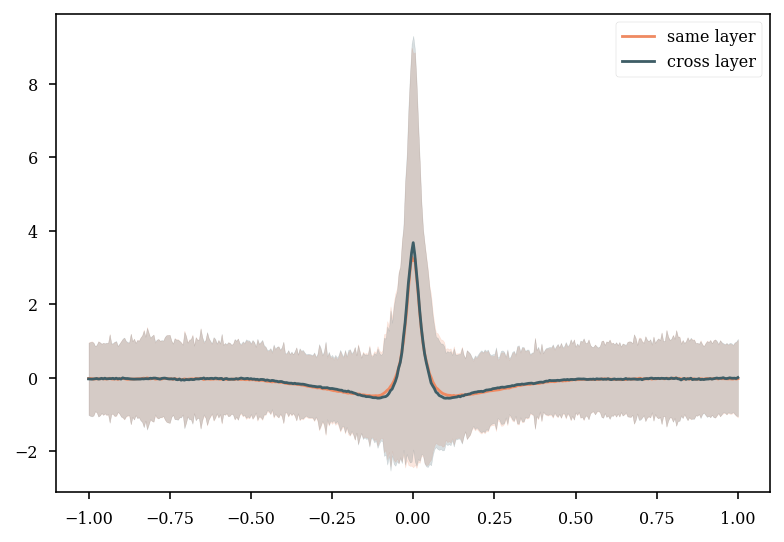

In [207]:
group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}

idx = ccg_id_df.layer_label == "same_layer"
y = np.nanmean(ccgs_z.loc[:,idx],axis=1)
x = ccgs_z.index
std = np.nanstd(ccgs_z.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

idx = ccg_id_df.layer_label == "cross_layer"
y = np.nanmean(ccgs_z.loc[:,idx],axis=1)
x = ccgs_z.index
sem = np.nanstd(ccgs_z.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)
plt.legend()
plt.show()

## Mean raw ccg -.2 to .2 sec

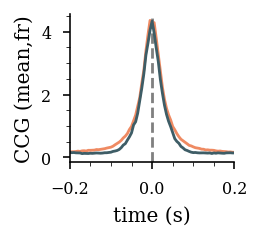

In [219]:
from matplotlib.ticker import AutoMinorLocator

group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}

fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1.5, 1)), edgecolor='k')

idx = ccg_id_df.layer_label == "same_layer"
y = np.nanmean(ccgs.loc[:,idx],axis=1)
x = ccgs.index
std = np.nanstd(ccgs.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
# plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

idx = ccg_id_df.layer_label == "cross_layer"
y = np.nanmean(ccgs.loc[:,idx],axis=1)
x = ccgs.index
sem = np.nanstd(ccgs.loc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
# plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)
plt.xlim(-.2,.2)
plt.axvline(0, color='grey', linestyle='--',zorder=-100)
plt.ylabel('CCG (mean,fr)')
plt.xlabel('time (s)')
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_ccg_deep_sup.svg'),dpi=300,bbox_inches='tight')
plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_ccg_deep_sup.jpeg'),dpi=300,bbox_inches='tight')
